<a href="https://colab.research.google.com/github/chavan-akshay/Condition-Monitoring-of-Aircraft-Engine/blob/main/Feed_forward_network_for_RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import itertools

## Importing the Dataset

In [ ]:
TrainDataset = pd.read_csv('train.txt', sep=' ', header = None)
TrainDataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,NaN,NaN
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,NaN,NaN
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,NaN,NaN
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,NaN,NaN
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,NaN,NaN
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,NaN,NaN
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,NaN,NaN
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,NaN,NaN


## Checking for Missing values

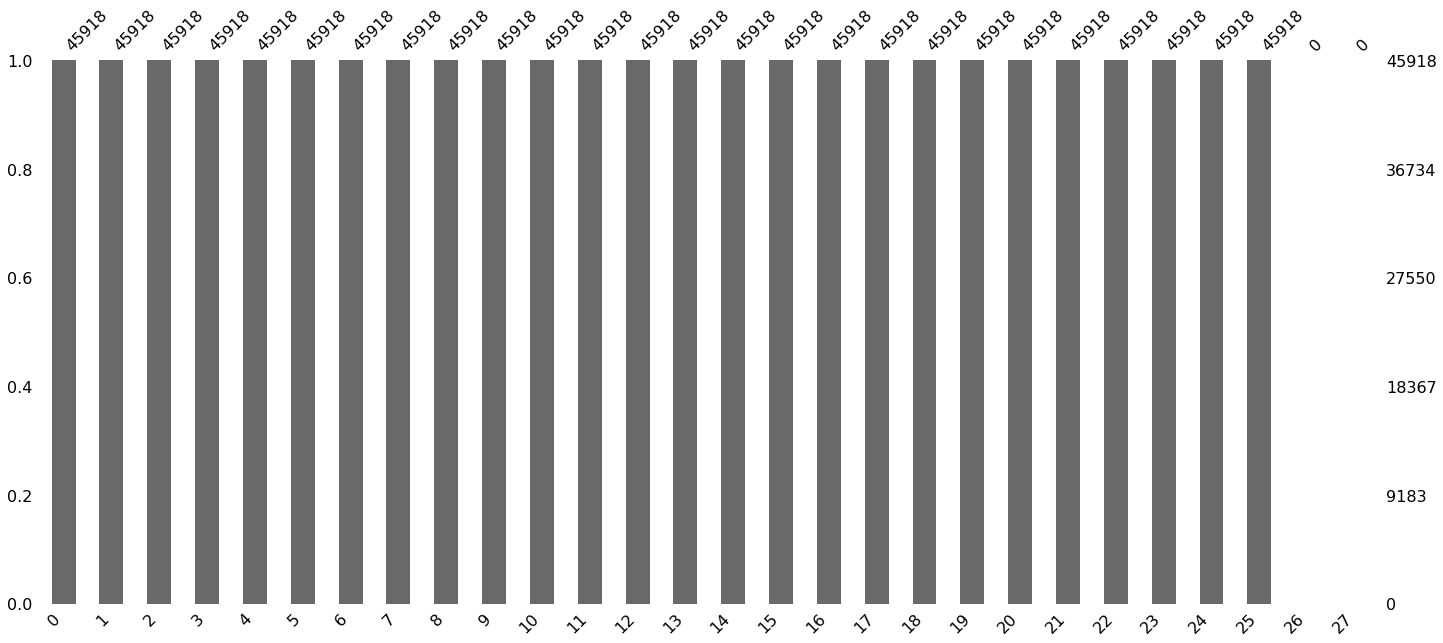

In [ ]:
import missingno as msno
msno.bar(TrainDataset)

## Adding Headings to different columns

In [ ]:
TrainDataset = TrainDataset[[f for f in range(0,26)]]
TrainDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
TrainDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


## Viewing Data for Engine Unit 1

In [ ]:
TrainDataset[TrainDataset['ID'] == 1]

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,219,35.0073,0.8400,60.0,449.44,556.39,1381.50,1149.74,5.48,8.00,194.02,2223.10,8368.35,1.02,42.50,182.52,2388.11,8068.10,9.4265,0.02,337,2223,100.0,14.82,8.7966
219,1,220,35.0027,0.8400,60.0,449.44,556.65,1375.43,1149.45,5.48,8.00,193.96,2223.01,8354.44,1.02,42.46,182.73,2388.15,8068.06,9.4148,0.02,338,2223,100.0,14.75,8.8290
220,1,221,0.0008,0.0000,100.0,518.67,643.88,1593.26,1425.82,14.62,21.61,551.14,2388.22,9069.36,1.30,48.17,520.04,2388.28,8139.03,8.5363,0.03,394,2388,100.0,38.67,23.0218
221,1,222,20.0003,0.7001,0.0,491.19,608.00,1494.99,1270.18,9.35,13.66,333.03,2324.18,8743.42,1.07,45.04,313.64,2388.37,8065.53,9.2846,0.03,369,2324,100.0,24.28,14.5645


## Finding the max. cycles for every unit ID

In [ ]:
max_cycles = TrainDataset.groupby(['ID'], sort = False)                         #Used to group the engine with same ID together
max_cycles_maxv = max_cycles['Cycle'].max()                                     #Used to find max value of cycle in that particular group
max_cycles_df = max_cycles_maxv.reset_index()                                   #Used to shift the index column as data column to be used as a cycle number.
max_cycles_df = max_cycles_df.rename(columns={'Cycle':'MaxCycleID'})            #Used to give both column a header name
max_cycles_df

,ID,MaxCycleID
0,1,223
1,2,164
2,3,150
3,4,159
4,5,357
...,...,...
213,214,150
214,215,156
215,216,190
216,217,287


## Defining target variable - Remaining Useful Life (RUL)

In [ ]:
TrainDataset = pd.merge(TrainDataset, max_cycles_df, how='inner', on='ID')      #Merge of the max_cycle_df in actual dataset 
TrainDataset['RUL'] = TrainDataset['MaxCycleID'] - TrainDataset['Cycle']        #Defining RUL
TrainDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


# Calculating piecewise linear regression RUL value

In [ ]:
main_set = []
engine_number = TrainDataset['ID'].max()
for i in range(engine_number):
  df = TrainDataset[TrainDataset['ID'] == i+1]
  for k in df.index:
    if df.at[k,'RUL'] > 125:
      df.at[k,'RUL']=125
  else:
    pass
  main_set.append(df)
main_set = tuple(main_set)
final_train_set = pd.concat((main_set),axis=0)
TrainDataset = final_train_set
TrainDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,223,125
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,223,125
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,223,125
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,223,125
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,223,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,133,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,133,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,133,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,133,1


## RUL Graph for each EngineID

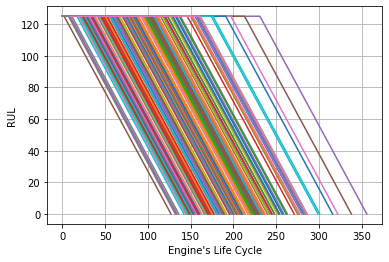

In [ ]:
one_engine = []                                                                 #Plotting RUL graphs for individual engines
for i,r in TrainDataset.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []

plt.xlabel("Engine's Life Cycle")    
plt.ylabel('RUL')    
plt.grid()
plt.savefig('RUL degradation.jpeg')

# Visualizing Correlation Matrix using Heatmap

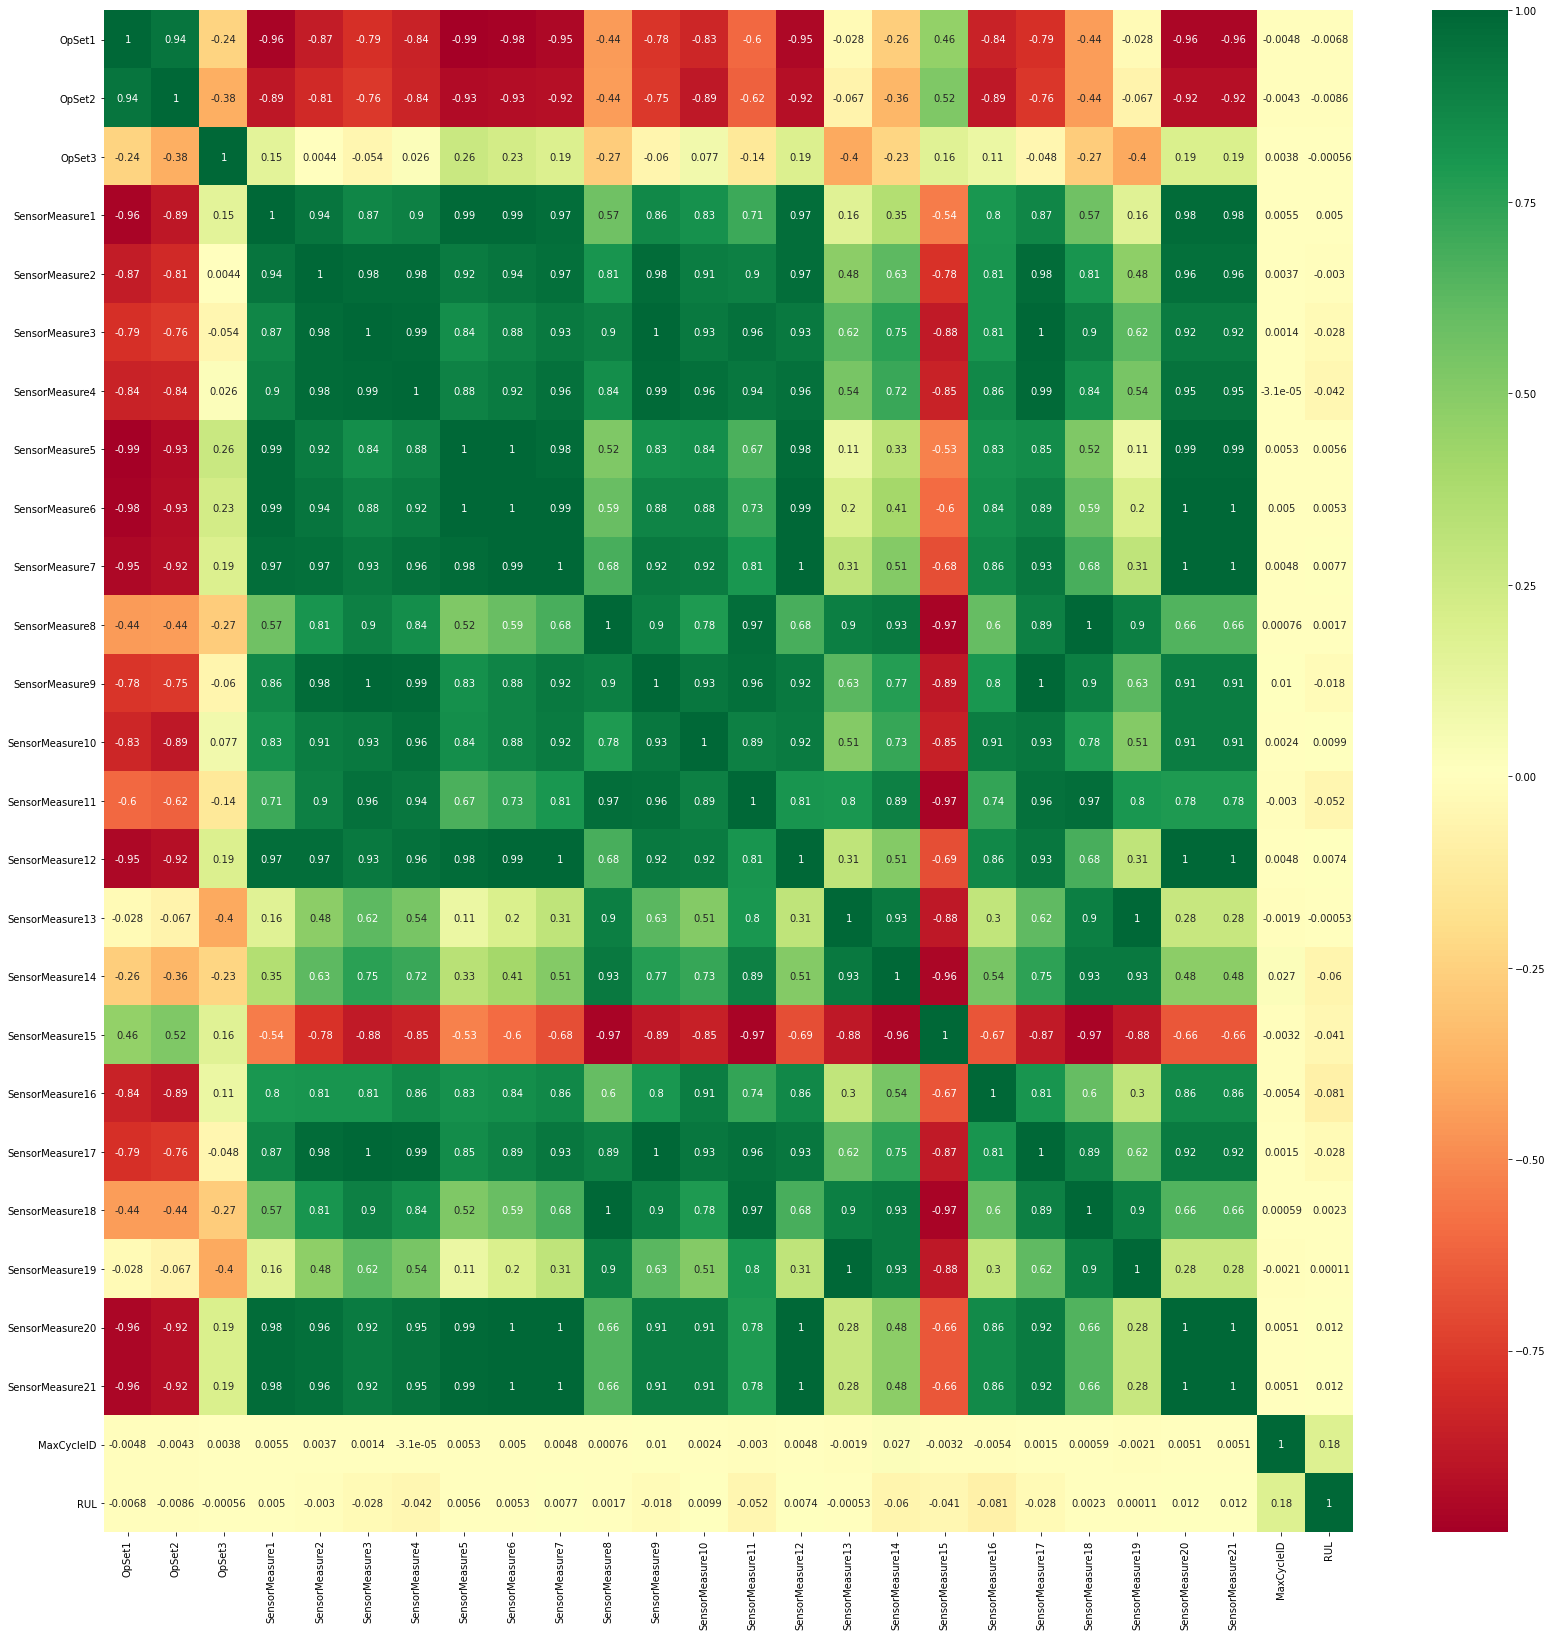

In [ ]:
import seaborn as sns
corrmat = TrainDataset.iloc[:,2:].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(28,28))
#plot heat map
g=sns.heatmap(TrainDataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Setting the Independent and Dependent Variables

In [ ]:
X_raw = TrainDataset.iloc[:, 2:-2]  #independent columns
y = TrainDataset.iloc[:,-1]     #dependent column
X_raw

,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,45.40,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,47.29,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,41.92,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,44.26,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,41.79,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,5.72,137.97,2211.33,8303.20,1.02,42.68,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,5.71,137.56,2211.29,8302.69,1.02,42.62,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,5.72,138.05,2211.24,8309.41,1.02,42.83,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,8.00,194.59,2222.54,8330.67,1.02,42.61,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


## Feature Selection

## Pearson correlation feature selection


In [ ]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define feature selection
fs = SelectKBest(score_func=f_regression, k='all')
# apply feature selection
X_selected = fs.fit(X_raw, y)

In [ ]:
dfscores2 = pd.DataFrame(X_selected.scores_) 
dfcolumns2 = pd.DataFrame(X_raw.columns)

In [ ]:
featureScores2 = pd.concat([dfcolumns2,dfscores2],axis=1)                       #Concatenating two dataframes for better visualization 
featureScores2.columns = ['Features','Score']                                   #Naming the dataframe columns

In [ ]:
print(featureScores2)

           Features       Score
0            OpSet1    2.123364
1            OpSet2    3.414579
2            OpSet3    0.014409
3    SensorMeasure1    1.133748
4    SensorMeasure2    0.414787
5    SensorMeasure3   36.368407
6    SensorMeasure4   79.698906
7    SensorMeasure5    1.417184
8    SensorMeasure6    1.268244
9    SensorMeasure7    2.695966
10   SensorMeasure8    0.137544
11   SensorMeasure9   15.615493
12  SensorMeasure10    4.489160
13  SensorMeasure11  122.366385
14  SensorMeasure12    2.547111
15  SensorMeasure13    0.013038
16  SensorMeasure14  167.338217
17  SensorMeasure15   76.002180
18  SensorMeasure16  302.274213
19  SensorMeasure17   36.215972
20  SensorMeasure18    0.236084
21  SensorMeasure19    0.000526
22  SensorMeasure20    6.655767
23  SensorMeasure21    6.753255


In [ ]:
print(featureScores2.nlargest(15, 'Score')) #print 10 best features

           Features       Score
18  SensorMeasure16  302.274213
16  SensorMeasure14  167.338217
13  SensorMeasure11  122.366385
6    SensorMeasure4   79.698906
17  SensorMeasure15   76.002180
5    SensorMeasure3   36.368407
19  SensorMeasure17   36.215972
11   SensorMeasure9   15.615493
23  SensorMeasure21    6.753255
22  SensorMeasure20    6.655767
12  SensorMeasure10    4.489160
1            OpSet2    3.414579
9    SensorMeasure7    2.695966
14  SensorMeasure12    2.547111
0            OpSet1    2.123364


##  Features Considered in Model

In [ ]:
Consid = TrainDataset[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12', 'RUL']]
Consid

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1,10.0047,0.2501,20.0,0.03,8120.83,45.40,1309.95,8.6216,1499.45,368,8770.20,17.1735,28.58,1.26,394.88,372.15,125
1,1,0.0015,0.0003,100.0,0.03,8132.87,47.29,1403.96,8.3907,1584.55,391,9045.76,23.3619,38.99,1.30,553.67,521.81,125
2,1,34.9986,0.8401,60.0,0.02,8063.84,41.92,1122.49,9.3557,1368.17,334,8343.91,8.8555,14.83,1.02,194.93,183.26,125
3,1,20.0031,0.7005,0.0,0.02,8052.30,44.26,1249.18,9.2231,1488.44,364,8721.53,14.7832,24.42,1.08,334.82,314.84,125
4,1,42.0041,0.8405,40.0,0.02,8083.67,41.79,1124.32,9.2986,1354.48,330,8314.56,6.4025,10.99,1.02,138.24,130.44,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,42.0066,0.8400,40.0,0.02,8062.87,42.68,1147.43,9.4672,1365.27,333,8303.20,6.2985,10.57,1.02,137.97,130.21,4
45914,218,42.0029,0.8415,40.0,0.02,8062.05,42.62,1142.21,9.4619,1365.55,332,8302.69,6.2741,10.40,1.02,137.56,130.24,3
45915,218,41.9999,0.8400,40.0,0.02,8062.73,42.83,1150.15,9.4827,1359.21,334,8309.41,6.1978,10.37,1.02,138.05,129.86,2
45916,218,35.0007,0.8419,60.0,0.02,8043.21,42.61,1145.49,9.4212,1380.05,337,8330.67,8.6761,14.70,1.02,194.59,182.03,1


# Creating Separate preprocessed CSV files for train and test set.

In [ ]:
sets = Consid.groupby(['ID'], sort = False)
for no, i in sets: 
  set = pd.DataFrame(i) 
  set.to_csv('csv_example{}.csv'.format(no), index=False)

In [ ]:
import os
import glob
os.chdir("Tempdata")

In [ ]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
all_filenames

In [ ]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ]) 
#export to csv
combined_csv.to_csv( "RUL_175_train_engines.csv", index=False, encoding='utf-8-sig')

# Calling training part of train dataset

In [ ]:
sequences = pd.read_csv('RUL_175_train_engines.csv', sep=',', header = 0)
sequences = sequences.iloc[:, 0:]
sequences

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1,10.0047,0.2501,20.0,0.03,8120.83,45.40,1309.95,8.6216,1499.45,368,8770.20,17.1735,28.58,1.26,394.88,372.15,125
1,1,0.0015,0.0003,100.0,0.03,8132.87,47.29,1403.96,8.3907,1584.55,391,9045.76,23.3619,38.99,1.30,553.67,521.81,125
2,1,34.9986,0.8401,60.0,0.02,8063.84,41.92,1122.49,9.3557,1368.17,334,8343.91,8.8555,14.83,1.02,194.93,183.26,125
3,1,20.0031,0.7005,0.0,0.02,8052.30,44.26,1249.18,9.2231,1488.44,364,8721.53,14.7832,24.42,1.08,334.82,314.84,125
4,1,42.0041,0.8405,40.0,0.02,8083.67,41.79,1124.32,9.2986,1354.48,330,8314.56,6.4025,10.99,1.02,138.24,130.44,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,99,34.9984,0.8400,60.0,0.02,8138.41,42.62,1148.69,9.4017,1374.69,337,8425.51,8.8880,14.75,1.02,193.65,182.88,4
36949,99,35.0045,0.8401,60.0,0.02,8133.41,42.55,1153.30,9.4013,1381.35,336,8423.27,8.7961,14.70,1.02,193.69,182.85,3
36950,99,24.9990,0.6200,80.0,0.02,7937.38,37.29,1065.66,11.0166,1276.94,310,8065.38,8.4360,14.23,0.94,174.78,163.76,2
36951,99,34.9996,0.8415,60.0,0.02,8136.76,42.41,1151.08,9.4250,1378.58,338,8428.03,8.8040,14.72,1.02,193.67,183.29,1


## Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
MMS = MinMaxScaler() 
t_sequences = MMS.fit_transform(sequences.iloc[:, :-1])                         #Scaling independent variables t_sequences

## Changing array back to Dataframe

In [ ]:
tp_sequences = pd.DataFrame(t_sequences) 
tp_sequences.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences = pd.concat([tp_sequences,sequences.iloc[:,-1:]],axis=1) 
tp_sequences

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,0.000000,0.238162,0.297031,0.2,1.0,0.635850,0.754516,0.679294,0.108151,0.687074,0.684211,0.636176,0.632556,0.630584,0.891892,0.616106,0.616366,125
1,0.000000,0.000036,0.000356,1.0,1.0,0.664311,0.909688,0.906993,0.023871,0.918217,0.926316,0.860647,0.986910,0.988316,1.000000,0.995107,0.996118,125
2,0.000000,0.833141,0.997743,0.6,0.0,0.501135,0.468801,0.225253,0.376100,0.330499,0.326316,0.288921,0.156259,0.158076,0.243243,0.138864,0.137072,125
3,0.000000,0.476174,0.831948,0.0,0.0,0.473856,0.660920,0.532105,0.327700,0.657169,0.642105,0.596530,0.495685,0.487629,0.405405,0.472755,0.470946,125
4,0.000000,0.999907,0.998219,0.4,0.0,0.548010,0.458128,0.229685,0.355258,0.293316,0.284211,0.265013,0.015798,0.026117,0.243243,0.003556,0.003045,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,0.563218,0.833137,0.997625,0.6,0.0,0.677406,0.526273,0.288711,0.392890,0.348209,0.357895,0.355393,0.158120,0.155326,0.243243,0.135809,0.136108,4
36949,0.563218,0.833282,0.997743,0.6,0.0,0.665587,0.520525,0.299876,0.392744,0.366298,0.347368,0.353568,0.152858,0.153608,0.243243,0.135905,0.136031,3
36950,0.563218,0.595101,0.736342,0.8,0.0,0.202203,0.088670,0.087606,0.982334,0.082706,0.073684,0.062032,0.132239,0.137457,0.027027,0.090770,0.087592,2
36951,0.563218,0.833165,0.999406,0.6,0.0,0.673506,0.509031,0.294499,0.401394,0.358774,0.368421,0.357445,0.153311,0.154296,0.243243,0.135857,0.137148,1


In [ ]:
train_x = tp_sequences.iloc[:,1:-1]
train_y = tp_sequences.iloc[:,-1]
train_x = torch.FloatTensor(train_x.values)
train_y = torch.FloatTensor(train_y.values)

print(train_x.shape)

torch.Size([36953, 16])


# Calling testing part of train dataset

In [ ]:
sequences_test = pd.read_csv('RUL_42_Train-test_engines.csv', sep=',', header = 0)

sequences_test

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,176,42.0064,0.8415,40.0,0.02,8092.29,41.90,1118.02,9.3506,1349.63,328,8316.61,6.3693,10.76,1.02,138.78,131.30,125
1,176,20.0008,0.7018,0.0,0.02,8060.73,44.07,1242.39,9.1577,1477.05,363,8727.31,14.7870,24.70,1.08,335.86,315.59,125
2,176,20.0011,0.7003,0.0,0.02,8059.94,43.88,1231.55,9.1827,1478.13,364,8727.10,14.8626,24.70,1.08,334.54,315.37,125
3,176,42.0035,0.8400,40.0,0.02,8088.90,41.83,1121.01,9.3558,1348.29,330,8320.12,6.4492,10.69,1.02,139.18,130.84,125
4,176,20.0072,0.7000,0.0,0.02,8063.52,44.09,1240.90,9.1725,1480.43,363,8720.39,14.8051,24.42,1.08,334.93,315.64,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,218,42.0066,0.8400,40.0,0.02,8062.87,42.68,1147.43,9.4672,1365.27,333,8303.20,6.2985,10.57,1.02,137.97,130.21,4
8706,218,42.0029,0.8415,40.0,0.02,8062.05,42.62,1142.21,9.4619,1365.55,332,8302.69,6.2741,10.40,1.02,137.56,130.24,3
8707,218,41.9999,0.8400,40.0,0.02,8062.73,42.83,1150.15,9.4827,1359.21,334,8309.41,6.1978,10.37,1.02,138.05,129.86,2
8708,218,35.0007,0.8419,60.0,0.02,8043.21,42.61,1145.49,9.4212,1380.05,337,8330.67,8.6761,14.70,1.02,194.59,182.03,1


In [ ]:
t_sequences_test = MMS.transform(sequences_test.iloc[:, :-1])                   #Scaling independent variables
tp_sequences_test = pd.DataFrame(t_sequences_test)
tp_sequences_test.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences_test = pd.concat([tp_sequences_test,sequences_test.iloc[:,-1:]],axis=1)
tp_sequences_test

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1.005747,0.999962,0.999406,0.4,0.0,0.568386,0.467159,0.214426,0.374238,0.280142,0.263158,0.266683,0.013897,0.018213,0.243243,0.004845,0.005227,125
1,1.005747,0.476119,0.833492,0.0,0.0,0.493783,0.645320,0.515659,0.303829,0.626232,0.631579,0.601238,0.495903,0.497251,0.405405,0.475237,0.472850,125
2,1.005747,0.476126,0.831710,0.0,0.0,0.491916,0.629721,0.489403,0.312954,0.629166,0.642105,0.601067,0.500232,0.497251,0.405405,0.472086,0.472291,125
3,1.005747,0.999893,0.997625,0.4,0.0,0.560373,0.461412,0.221668,0.376136,0.276503,0.284211,0.269542,0.018472,0.015808,0.243243,0.005800,0.004060,125
4,1.005747,0.476271,0.831354,0.0,0.0,0.500378,0.646962,0.512050,0.309231,0.635413,0.631579,0.595601,0.496939,0.487629,0.405405,0.473017,0.472976,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,1.247126,0.999967,0.997625,0.4,0.0,0.498842,0.531199,0.285659,0.416797,0.322623,0.315789,0.255759,0.009843,0.011684,0.243243,0.002912,0.002461,4
8706,1.247126,0.999879,0.999406,0.4,0.0,0.496903,0.526273,0.273016,0.414863,0.323383,0.305263,0.255344,0.008446,0.005842,0.243243,0.001933,0.002537,3
8707,1.247126,0.999807,0.997625,0.4,0.0,0.498511,0.543514,0.292247,0.422455,0.306163,0.326316,0.260818,0.004077,0.004811,0.243243,0.003103,0.001573,2
8708,1.247126,0.833191,0.999881,0.6,0.0,0.452369,0.525452,0.280960,0.400007,0.362767,0.357895,0.278136,0.145987,0.153608,0.243243,0.138053,0.133951,1


In [ ]:
test_x = tp_sequences_test.iloc[:,1:-1]
test_y = tp_sequences_test.iloc[:,-1]
test_x = torch.FloatTensor(test_x.values)
test_y = torch.FloatTensor(test_y.values)

print(test_x.shape)

torch.Size([8710, 16])


# Creating a validation set

In [ ]:
sequences_valid = pd.read_csv('RULcsv_example178.csv', sep=',', header = 0)
t_sequences_valid = MMS.transform(sequences_valid.iloc[:, :-1])                 #Scaling independent variables
tp_sequences_valid = pd.DataFrame(t_sequences_valid)
tp_sequences_valid.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
tp_sequences_valid = pd.concat([tp_sequences_valid,sequences_valid.iloc[:,-1:]],axis=1)
tp_sequences_valid

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12,RUL
0,1.017241,0.238005,0.297387,0.2,1.0,0.673199,0.751232,0.652191,0.121911,0.668659,0.684211,0.644453,0.636622,0.623711,0.891892,0.615008,0.615605,125
1,1.017241,0.999924,0.997625,0.4,0.0,0.540540,0.448276,0.210139,0.363105,0.274004,0.273684,0.273892,0.015575,0.016151,0.243243,0.004535,0.003121,125
2,1.017241,0.999781,0.997625,0.4,0.0,0.563209,0.461412,0.204568,0.360696,0.284570,0.273684,0.273265,0.012116,0.020962,0.243243,0.004917,0.002588,125
3,1.017241,0.238131,0.296912,0.2,1.0,0.658898,0.755337,0.650592,0.112275,0.670044,0.684211,0.640152,0.627374,0.632990,0.891892,0.615151,0.615935,125
4,1.017241,0.238083,0.297150,0.2,1.0,0.665871,0.735632,0.670623,0.109903,0.678572,0.673684,0.644616,0.640075,0.634364,0.891892,0.616942,0.616341,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1.017241,0.833208,0.997981,0.6,0.0,0.587391,0.502463,0.271030,0.399679,0.351468,0.357895,0.325652,0.152400,0.159450,0.243243,0.136812,0.135575,4
251,1.017241,0.833315,0.997862,0.6,0.0,0.583751,0.519704,0.275801,0.394897,0.369041,0.357895,0.327876,0.153522,0.152234,0.243243,0.136883,0.134458,3
252,1.017241,0.238150,0.298219,0.2,1.0,0.744421,0.816092,0.730206,0.160857,0.713067,0.726316,0.683007,0.620108,0.619931,0.891892,0.612216,0.613778,2
253,1.017241,0.595284,0.736342,0.8,0.0,0.122305,0.080460,0.092232,0.983903,0.051145,0.073684,0.052085,0.137541,0.136426,0.027027,0.091343,0.089470,1


In [ ]:
valid_x = tp_sequences_valid.iloc[:,1:-1]
valid_y = tp_sequences_valid.iloc[:,-1]
valid_x = torch.FloatTensor(valid_x.values)
valid_y = torch.FloatTensor(valid_y.values)

In [ ]:
class shape_dataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        return item,label

# Deep Feedforward model



In [ ]:
class FeedForward(nn.Module):
    def __init__(self,input_features=16,hidden1=40,hidden2=40,hidden3=10,out_features=1):
        super(FeedForward,self).__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1,hidden2)
        self.f_connected3=nn.Linear(hidden2,hidden3)
        self.Sig = nn.Sigmoid()
        self.out=nn.Linear(hidden3,out_features)

    def forward(self,x):
        x = self.f_connected1(x)
        x = F.relu(x)
        x = self.f_connected2(x)
        x = F.relu(x)
        x = self.f_connected3(x)
        x = x
        x = self.out(x)
        return x

Creating RMSLE Loss function

In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(torch.log(yhat + 1), torch.log(y + 1)) + self.eps)
        return loss

# Defining Train function

In [ ]:
def Train(train_loader):
    
    running_loss = .0
    model.train()
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.reshape(labels.shape[0],1)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    sample_loss = running_loss/len(train_loader)
    print('The train set loss is *****', format(sample_loss.item()))
    return sample_loss

# Defining Test function

In [ ]:
def Test(data_loader):
    running_loss = .0
    actual = []
    predict = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape(labels.shape[0],1)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels.float())
            running_loss += loss
            
        sample_loss = running_loss/len(data_loader)
        print('The test set loss is: ', format(sample_loss.item()))
    return sample_loss

# Defining Validation function



In [ ]:
def Valid(data_loader):
    running_loss = .0
    actual = []
    predict = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape(labels.shape[0],1)
            optimizer.zero_grad()
            preds = model(inputs.float())
            predict.append(preds.item())
            actual.append(labels.item())
            #print(preds.item())
            loss = criterion(preds,labels.float())
            running_loss += loss

        sample_loss = running_loss/len(data_loader)
        print('The validation set loss is: ', format(sample_loss.item()))
    return (sample_loss, predict, actual)

# Model Training and Testing

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FeedForward().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = RMSLELoss()

In [ ]:
train_losses = []
test_losses = []
epochs = 120
for epoch in range(epochs):
    print('The epoch is....................................... {}/{}'.format(epoch+1,epochs))
    train = shape_dataset(train_x,train_y)
    train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
    sample_loss = Train(train_loader)
    train_losses.append(sample_loss.item())

    test = shape_dataset(test_x,test_y)
    test_loader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)
    sample_testloss = Test(test_loader)
    test_losses.append(sample_testloss.item())

    


The epoch is....................................... 1/20
The train_loss is ***** 0.17693114280700684
Accuracy of the network : 4.846697155846616
test_loss is  0.5286616086959839
Accuracy of the network :  0.9737318840579711
The epoch is....................................... 2/20
The train_loss is ***** 0.17726318538188934
Accuracy of the network : 4.554434010770438
test_loss is  0.4396749436855316
Accuracy of the network :  1.2228260869565217
The epoch is....................................... 3/20
The train_loss is ***** 0.17679159343242645
Accuracy of the network : 4.402890157767976
test_loss is  0.38953912258148193
Accuracy of the network :  1.2794384057971016
The epoch is....................................... 4/20
The train_loss is ***** 0.17602606117725372
Accuracy of the network : 4.43265770032203
test_loss is  0.3656584620475769
Accuracy of the network :  1.2567934782608696
The epoch is....................................... 5/20
The train_loss is ***** 0.17445005476474762
Acc

# Model validation

In [ ]:
valid = shape_dataset(valid_x,valid_y)
#valid = shape_dataset(overall_train_x,overall_train_y)
valid_loader = torch.utils.data.DataLoader(valid,batch_size=1,shuffle=False)
valid_loss, predict, actual = Valid(valid_loader)


The validation set loss is:  0.24113257229328156


### Model validation using 178th Engine ID

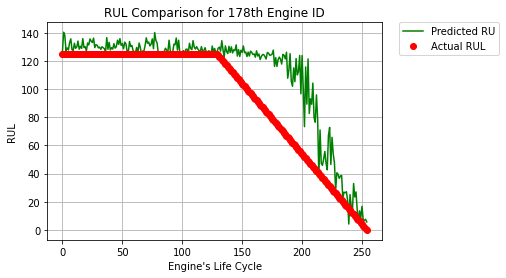

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 178th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Test Engine ID 178')

# RUL plot for Train Engine: Actual vs Predicted

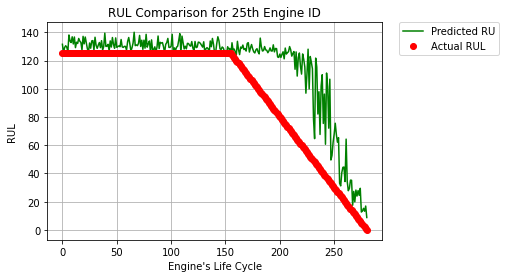

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 25th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Train Engine ID 25')

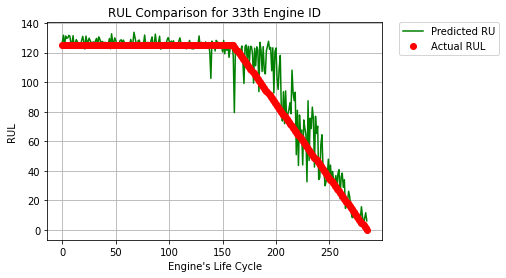

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 33th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Train Engine ID 33')

# RUL plot for Test engine: Actual vs Predicted

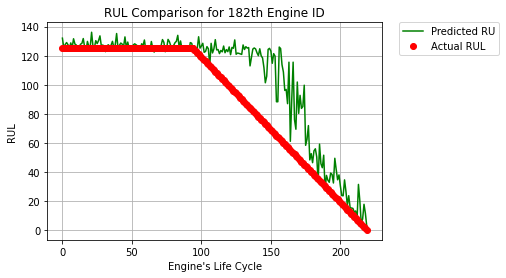

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 182th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Test Engine ID 182')

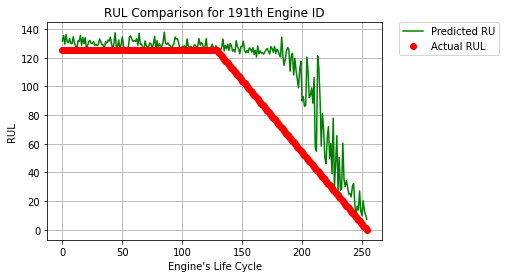

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 191th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Test Engine ID 191')

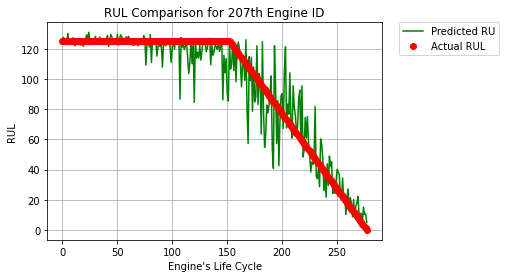

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 207th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Test Engine ID 207')

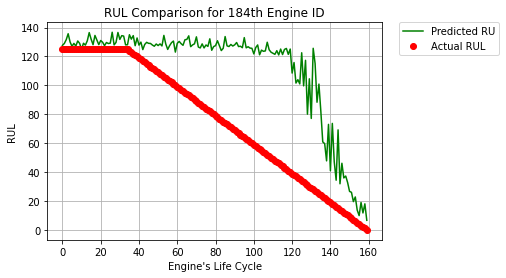

In [ ]:
plt.plot(predict, 'g',label='Predicted RU')
plt.plot(actual, 'ro', label='Actual RUL')
plt.title('RUL Comparison for 184th Engine ID')
plt.xlabel("Engine's Life Cycle")
plt.ylabel("RUL")     
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.grid()
plt.savefig('Deep feedforward Test Engine ID 184')

# Using entire train dataset for scoring functions

In [ ]:
overall_train = MMS.transform(Consid.iloc[:, :-1])                              #Scaling independent variables
overall_train = pd.DataFrame(overall_train)
overall_train.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
overall_train = pd.concat([overall_train,Consid.iloc[:,-1:]],axis=1)

overall_train_x = overall_train.iloc[:,1:-1]
overall_train_y = overall_train.iloc[:,-1]
overall_train_x = torch.FloatTensor(overall_train_x.values)
overall_train_y = torch.FloatTensor(overall_train_y.values)

# Scoring Metrics

## PHM Challenge scoring function

In [ ]:
import math
import itertools

def PHM_score1(predict, actual):
  total_score1 = .0
  for (yhat,y) in zip(predict, actual):
    d = yhat - y
    small = d/13
    large = d/10
    if d<0:
      score = (math.exp(-small)-1)
    else:
      score = (math.exp(large)-1)
    total_score1 = total_score1 + score
  return total_score1

def PHM_score2(predict, actual):
  total_score2 = .0
  for (yhat,y) in zip(predict, actual):
    d = yhat - y
    small = d/10
    large = d/13
    if d<0:
      score = (math.exp(-small)-1)
    else:
      score = (math.exp(large)-1)
    total_score2 = total_score2 + score
  return total_score2

In [ ]:
PHM_score1 = PHM_score1(predict,actual)
print(PHM_score1)

5573632.19314601


In [ ]:
PHM_score2 = PHM_score2(predict,actual)
print(PHM_score2)

1100171.0607741391


## R2 score for regression problem accuracy

In [ ]:
from sklearn.metrics import r2_score
R2_score = r2_score(actual, predict)
print(R2_score)

0.5605976652806088


## Mean Square Error

In [ ]:
def MSE(actual, predict):
  MSE_score = .0
  for (y,yhat) in zip(actual,predict):
    d = y - yhat
    score = math.pow(d,2)
    MSE_score = MSE_score + score
  MSE_score = MSE_score/len(actual)
  return MSE_score

In [ ]:
MSE_value = MSE(actual,predict)
print(MSE_value)

760.2805285766705


## Root Mean Square Error (RMSE)

In [ ]:
RMSE_value = math.sqrt(MSE_value)
print(RMSE_value)

27.57318495525445


# RUL prediction on given Test set

In [ ]:
TestDataset = pd.read_csv('test.txt', sep=' ', header = None)
TestDataset = TestDataset[[f for f in range(0,26)]]
TestDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
TestDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,21.61,553.33,2388.12,9042.41,1.30,47.57,521.44,2388.10,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,9.02,175.04,1915.12,7983.34,0.94,36.81,164.32,2027.95,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,21.61,554.31,2388.18,9037.61,1.30,47.49,521.15,2388.19,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,15.49,393.88,2318.94,8761.83,1.26,45.41,371.42,2388.21,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,21.61,553.53,2388.13,9041.98,1.30,47.66,520.86,2388.13,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29815,218,86,35.0013,0.8404,60.0,449.44,556.14,1367.80,1129.58,5.48,8.00,193.42,2222.90,8342.83,1.02,42.04,182.99,2388.01,8065.66,9.3426,0.02,335,2223,100.00,14.62,8.8457
29816,218,87,25.0041,0.6200,80.0,462.54,536.97,1262.93,1051.83,7.05,9.03,175.27,1915.34,8007.53,0.94,36.89,164.96,2028.18,7871.94,10.9421,0.02,306,1915,84.93,14.41,8.4964
29817,218,88,20.0043,0.7000,0.0,491.19,607.93,1492.15,1252.99,9.35,13.66,333.62,2324.06,8723.49,1.08,44.53,314.86,2388.09,8059.65,9.2862,0.02,368,2324,100.00,24.42,14.5244
29818,218,89,20.0037,0.7000,0.0,491.19,607.85,1490.80,1254.70,9.35,13.66,333.77,2324.00,8720.59,1.08,44.55,314.86,2388.09,8062.13,9.2599,0.02,365,2324,100.00,24.45,14.5694


In [ ]:
Test_consid = TestDataset[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']]
t_test_dataset = MMS.transform(Test_consid.iloc[:, :]) #Scaling independent variables
test_dataset = pd.DataFrame(t_test_dataset)
test_dataset.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
test_dataset 

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12
0,0.000000,0.000038,0.000238,1.0,1.0,0.643438,0.932677,0.927532,0.040515,0.925442,0.947368,0.857918,0.983532,0.987629,1.000000,0.994296,0.995179
1,0.000000,0.595108,0.738124,0.8,0.0,0.031581,0.049261,0.062853,0.937402,0.043866,0.052632,-0.004798,0.145557,0.139519,0.027027,0.091391,0.089013
2,0.000000,0.000010,0.000000,1.0,1.0,0.636536,0.926108,0.920508,0.049896,0.932341,0.947368,0.854008,0.981608,0.985567,1.000000,0.996635,0.994443
3,0.000000,0.238131,0.296912,0.2,1.0,0.642232,0.755337,0.692349,0.130014,0.688378,0.694737,0.629358,0.627947,0.631271,0.891892,0.613719,0.614514
4,0.000000,0.000057,0.001306,1.0,1.0,0.629870,0.940066,0.917068,0.049786,0.920716,0.936842,0.857568,0.984076,0.982474,1.000000,0.994773,0.993707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29815,1.247126,0.833206,0.998100,0.6,0.0,0.505437,0.478654,0.242425,0.371318,0.329495,0.336842,0.288042,0.155698,0.150859,0.243243,0.135260,0.136387
29816,1.247126,0.595222,0.736342,0.8,0.0,0.047513,0.055829,0.054109,0.955141,0.044653,0.031579,0.014907,0.135697,0.143643,0.027027,0.091940,0.090637
29817,1.247126,0.476202,0.831354,0.0,0.0,0.491230,0.683087,0.541333,0.350732,0.667246,0.684211,0.598126,0.480866,0.487629,0.405405,0.469890,0.470997
29818,1.247126,0.476188,0.831354,0.0,0.0,0.497092,0.684729,0.545474,0.341132,0.663579,0.652632,0.595764,0.483443,0.488660,0.405405,0.470248,0.470997


In [ ]:
major_test = test_dataset.iloc[:,1:]
major_test = torch.FloatTensor(major_test.values)
print(major_test.shape)

torch.Size([29820, 16])


In [ ]:
def Prediction(valid_loader):

    predict = []
    model.eval()

    with torch.no_grad():
        for idx, inputs in enumerate(valid_loader):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            predict.append(preds.item())
            #print(preds.item())

    return predict

In [ ]:
valid_loader1 = torch.utils.data.DataLoader(major_test,batch_size=1,shuffle=False)
Test_predict = Prediction(valid_loader1)

29820

In [ ]:
Test_predict = pd.DataFrame(Test_predict)
Test_predict.columns = ['RUL']
TestDataset = pd.concat([TestDataset,Test_predict],axis=1)
TestDataset.to_csv("FNN_Predicted_RUL_test_dataset.csv", index=False, encoding='utf-8-sig')

# RUL prediction on given Final Test set

In [ ]:
Final_TestDataset = pd.read_csv('final_test.txt', sep=' ', header = None)
Final_TestDataset = Final_TestDataset[[f for f in range(0,26)]]
Final_TestDataset.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8','SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
Final_TestDataset

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,10.0047,0.2501,20.0,489.05,605.02,1498.72,1304.90,10.52,15.49,394.90,2318.93,8770.87,1.26,45.47,371.83,2388.12,8128.58,8.6402,0.03,371,2319,100.0,28.52,17.0653
1,1,2,0.0015,0.0003,100.0,518.67,642.69,1592.90,1405.35,14.62,21.61,554.15,2388.03,9046.61,1.30,47.46,521.88,2388.09,8128.07,8.4286,0.03,392,2388,100.0,38.95,23.3609
2,1,3,34.9986,0.8401,60.0,449.44,555.49,1357.71,1127.52,5.48,8.00,194.57,2222.86,8340.55,1.02,41.80,182.97,2387.92,8060.07,9.3065,0.02,333,2223,100.0,14.91,8.8185
3,1,4,20.0031,0.7005,0.0,491.19,607.62,1479.86,1257.25,9.35,13.65,334.19,2323.95,8721.01,1.07,44.22,315.29,2388.09,8060.00,9.2381,0.02,365,2324,100.0,24.35,14.7075
4,1,5,42.0041,0.8405,40.0,445.00,549.69,1354.17,1124.17,3.91,5.72,139.03,2211.76,8318.64,1.02,41.98,130.50,2387.84,8080.66,9.3950,0.02,331,2212,100.0,10.67,6.4837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55151,435,43,34.9988,0.8405,60.0,449.44,555.54,1360.55,1122.22,5.48,8.00,193.34,2222.92,8342.28,1.02,41.81,183.53,2388.05,8067.98,9.2412,0.02,332,2223,100.0,15.00,8.8866
55152,435,44,0.0009,0.0004,100.0,518.67,642.41,1580.43,1395.30,14.62,21.61,554.26,2388.03,9056.05,1.30,47.29,522.48,2388.00,8134.27,8.4178,0.03,390,2388,100.0,39.04,23.3770
55153,435,45,35.0079,0.8407,60.0,449.44,555.04,1361.70,1123.09,5.48,8.00,194.89,2222.98,8355.74,1.02,41.57,183.31,2388.02,8068.46,9.2743,0.02,333,2223,100.0,14.98,8.8724
55154,435,46,10.0078,0.2508,20.0,489.05,604.63,1497.26,1297.02,10.52,15.49,395.31,2318.82,8776.68,1.26,45.11,372.49,2388.03,8131.63,8.6161,0.03,369,2319,100.0,28.67,17.3183


In [ ]:
Final_Test_consid = Final_TestDataset[['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']]
t_finaltest_dataset = MMS.transform(Final_Test_consid.iloc[:, :]) #Scaling independent variables
final_test_dataset = pd.DataFrame(t_finaltest_dataset)
final_test_dataset.columns = ['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure16', 'SensorMeasure14', 'SensorMeasure11', 'SensorMeasure4', 'SensorMeasure15', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure9', 'SensorMeasure21', 'SensorMeasure20', 'SensorMeasure10', 'SensorMeasure7', 'SensorMeasure12']
final_test_dataset 

,ID,OpSet1,OpSet2,OpSet3,SensorMeasure16,SensorMeasure14,SensorMeasure11,SensorMeasure4,SensorMeasure15,SensorMeasure3,SensorMeasure17,SensorMeasure9,SensorMeasure21,SensorMeasure20,SensorMeasure10,SensorMeasure7,SensorMeasure12
0,0.000000,0.238162,0.297031,0.2,1.0,0.654170,0.760263,0.667062,0.114940,0.685091,0.715789,0.636722,0.626361,0.628522,0.891892,0.616154,0.615554
1,0.000000,0.000036,0.000356,1.0,1.0,0.652964,0.923645,0.910359,0.037705,0.940897,0.936842,0.861339,0.986853,0.986942,1.000000,0.996253,0.996295
2,0.000000,0.833141,0.997743,0.6,0.0,0.492223,0.458949,0.237436,0.358141,0.302089,0.315789,0.286184,0.154141,0.160825,0.243243,0.138005,0.136336
3,0.000000,0.476174,0.831948,0.0,0.0,0.492057,0.657635,0.551651,0.333175,0.633865,0.652632,0.596106,0.491351,0.485223,0.378378,0.471251,0.472088
4,0.000000,0.999907,0.998219,0.4,0.0,0.540894,0.473727,0.229322,0.390444,0.292474,0.294737,0.268337,0.020448,0.015120,0.243243,0.005442,0.003197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55151,2.494253,0.833146,0.998219,0.6,0.0,0.510921,0.459770,0.224599,0.334307,0.309803,0.305263,0.287594,0.158040,0.163918,0.243243,0.135069,0.137757
55152,2.494253,0.000021,0.000475,1.0,1.0,0.667620,0.909688,0.886017,0.033763,0.907027,0.915789,0.869029,0.987775,0.990034,1.000000,0.996515,0.997818
55153,2.494253,0.833363,0.998456,0.6,0.0,0.512056,0.440066,0.226706,0.346388,0.312926,0.315789,0.298558,0.157227,0.163230,0.243243,0.138769,0.137199
55154,2.494253,0.238236,0.297862,0.2,1.0,0.661380,0.730706,0.647976,0.106143,0.681126,0.694737,0.641455,0.640848,0.633677,0.891892,0.617132,0.617229


In [ ]:
final_test = final_test_dataset.iloc[:,1:]
final_test = torch.FloatTensor(final_test.values)
print(final_test.shape)

torch.Size([55156, 16])


In [ ]:
valid_loader2 = torch.utils.data.DataLoader(final_test,batch_size=1,shuffle=False)
Final_Test_predict = Prediction(valid_loader2)

In [ ]:
Final_Test_predict = pd.DataFrame(Final_Test_predict)
Final_Test_predict.columns = ['RUL']
Final_TestDataset = pd.concat([Final_TestDataset,Final_Test_predict],axis=1)
Final_TestDataset.to_csv("FNN_Predicted_RUL_Final_test_dataset.csv", index=False, encoding='utf-8-sig')